# Data analysis Interview Challenge

## Part 1 -  Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose


# library for modeling 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-colorblind')

In [2]:
df = pd.read_json('logins.json')

In [3]:
df.head(2)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10


In [4]:
# find the frequency
print(df['login_time'].dt.freq)

None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
df.dtypes 

login_time    datetime64[ns]
dtype: object

In [7]:
df.isnull().sum(),

(login_time    0
 dtype: int64,)

In [8]:
df.duplicated().sum()

877

In [9]:
df.shape

(93142, 1)

In [10]:
df = df.drop_duplicates()

In [11]:
df.shape , df.duplicated().sum()

((92265, 1), 0)

In [12]:
df.describe()

C:\Users\mirei\AppData\Local\Temp/ipykernel_28836/3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,login_time
count,92265
unique,92265
top,1970-01-01 20:13:18
freq,1
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [13]:
df= df.set_index('login_time')

In [14]:
df.head(2)

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10


In [15]:
# add 'count' column
df['count_15mn'] = 0
df = df.resample('15T').count()
df = df.reset_index()
df.head()

,login_time,count_15mn
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


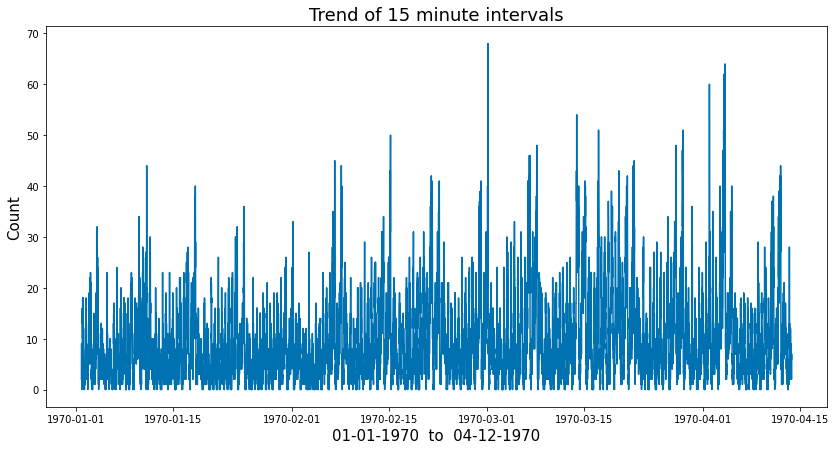

In [16]:
fig, ax = plt.subplots(figsize=(14,7))
sns.lineplot(data=df, x="login_time", y="count_15mn",  ci=None)
ax.set_title('Trend of 15 minute intervals',fontsize=18)
ax.set_xlabel('01-01-1970  to  04-12-1970',fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.show()

#The time series length is from january  to mid April1970. 

[Text(0.5, 1.0, 'Login Times Grouped by Time (Mean)'),
 Text(0, 0.5, 'count'),
 Text(0.5, 0, 'time')]

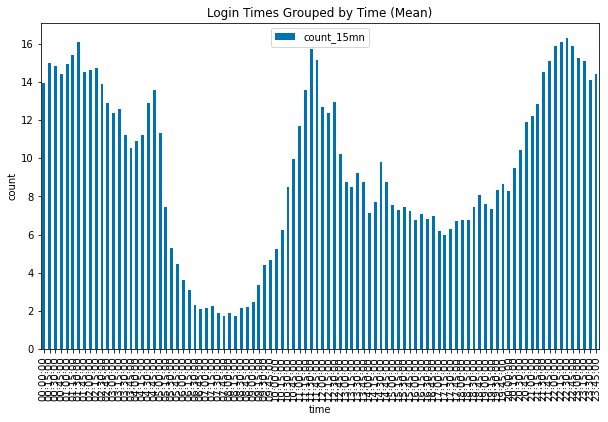

In [17]:
df['date_time'] = df.login_time.dt.time
ax = df.groupby('date_time').mean().plot(kind='bar')
ax.set(title='Login Times Grouped by Time (Mean)', ylabel='count', xlabel='time')
#ax.get_legend().remove()

The time series data may have multiplicative or additive components. 
Decomposition helps us to better analyze the data.
Time series decomposition splits the series into several components:
●	level: the average value in the series.
●	trend: the increasing or decreasing value in the series.
●	seasonality: the repeating short-term cycle in the series.
●	noise: the random variation in the series

the time series data containing the timestamps of user logins is a dataset with 93142 observations.  we found 877 duplicated values and we dropped them. the plotting of time series based on 15 minutes intervals (aggregate) did not help us to better visualize the underline pattern. Time series decomposition splits the series into several components. This helped us to better visualize the underline pattern. we found that: 
the time series tend to be multiplicative 
the series has a weekly seasonal pattern.
the trend is increasing with a slight decrease at the end of April
the Noice is pronounced, this variability could impact model building and cannot be explained by the model.

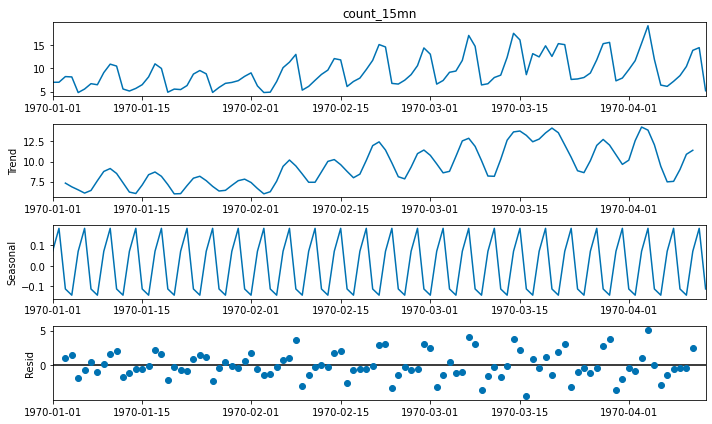

In [18]:
df= df.set_index('login_time')
count_15mn_W = seasonal_decompose(df['count_15mn'].resample('D').mean(), period = 4).plot()
plt.show()

Text(0.5, 1.0, 'Trend of 15 minute intervals')

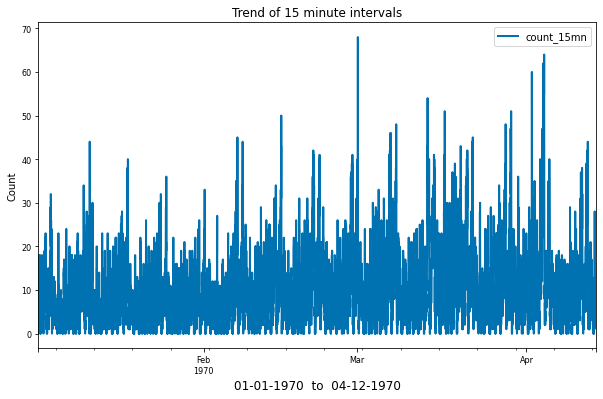

In [19]:
ax = df[['count_15mn']].plot(linewidth=2, fontsize=8)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlabel('01-01-1970  to  04-12-1970',fontsize=12)
ax.set_title('Trend of 15 minute intervals', fontsize=12)

Text(0.5, 1.0, 'Trend of 15 minute intervals')

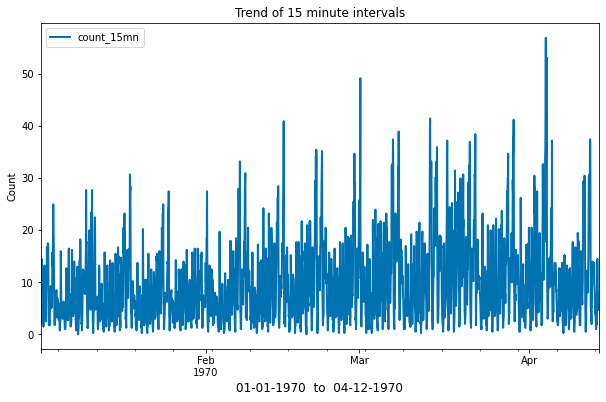

In [20]:
# smoot the time serie, resample by Hour
ax = df[['count_15mn']].resample('H').mean().plot(linewidth=2, fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlabel('01-01-1970  to  04-12-1970',fontsize=12)
ax.set_title('Trend of 15 minute intervals', fontsize=12)

Text(0.5, 1.0, 'Trend of 15 minute intervals')

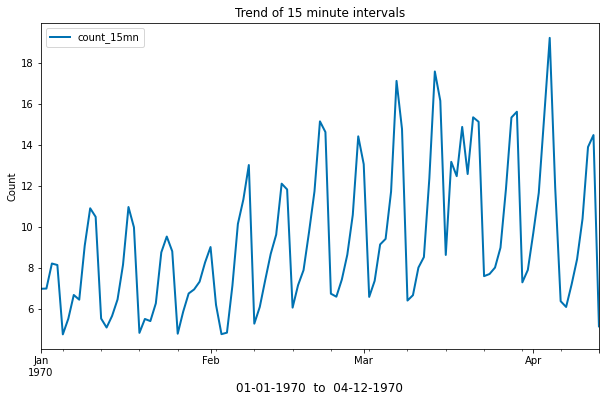

In [21]:
# smoot the time serie, resample by day
ax = df[['count_15mn']].resample('D').mean().plot(linewidth=2, fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlabel('01-01-1970  to  04-12-1970',fontsize=12)
ax.set_title('Trend of 15 minute intervals', fontsize=12)

Text(0.5, 1.0, 'Trend of 15 minute intervals')

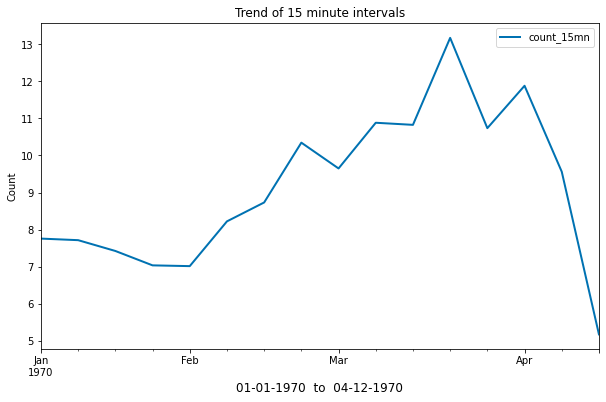

In [22]:
# smoot the time serie, resample by week
ax = df[['count_15mn']].resample('W').mean().plot(linewidth=2, fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_xlabel('01-01-1970  to  04-12-1970',fontsize=12)
ax.set_title('Trend of 15 minute intervals', fontsize=12)

Finaly , We assessed the stationarity of the time series using Augmented Dickey-Fuller Test (ADF test) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests. in fact, A Stationary time series is one whose statistical properties like mean, variance, covariance does not vary or change over time. according to ADF test, the series is stationary and, KPSS test showed that the series is not stationary. 

In [23]:
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

adfuller_test(df['count_15mn'], name='count_15mn')

 count_15mn : P-Value = 0.0 => Stationary. 


In [24]:
def kpss_test(series, sig=0.05, name=''):
    statistic, p_value, n_lags, critical_values = kpss(series, nlags='auto')    
    p_value = round(p_value, 3) 
    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Non Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => stationary.")
        

kpss_test(df['count_15mn'], sig=0.05, name='count_15mn')

 count_15mn : P-Value = 0.01 => Non Stationary. 


C:\Users\mirei\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [25]:
# get the month, week, day, hour, minute and day of the week 
df.reset_index().head(2)
df1=df.copy().reset_index()
df1['month']=df1['login_time'].dt.month
df1['week']=df1['login_time'].dt.week
df1['day']=df1['login_time'].dt.day
df1['hour']=df1['login_time'].dt.hour
df1['minute']=df1['login_time'].dt.minute
df1['day_of_week'] = df1['login_time'].dt.day_name()

df1.head(3)

C:\Users\mirei\AppData\Local\Temp/ipykernel_28836/18593308.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['week']=df1['login_time'].dt.week


,login_time,count_15mn,date_time,month,week,day,hour,minute,day_of_week
0,1970-01-01 20:00:00,2,20:00:00,1,1,1,20,0,Thursday
1,1970-01-01 20:15:00,6,20:15:00,1,1,1,20,15,Thursday
2,1970-01-01 20:30:00,9,20:30:00,1,1,1,20,30,Thursday


In [26]:
df1.groupby("day_of_week")['count_15mn'].count()

day_of_week
Friday       1440
Monday       1420
Saturday     1440
Sunday       1440
Thursday     1360
Tuesday      1344
Wednesday    1344
Name: count_15mn, dtype: int64

In [27]:
df1.groupby("day_of_week")['login_time'].count()

day_of_week
Friday       1440
Monday       1420
Saturday     1440
Sunday       1440
Thursday     1360
Tuesday      1344
Wednesday    1344
Name: login_time, dtype: int64

<AxesSubplot:title={'center':'Login Frequency by day_of_week'}, ylabel='day_of_week'>

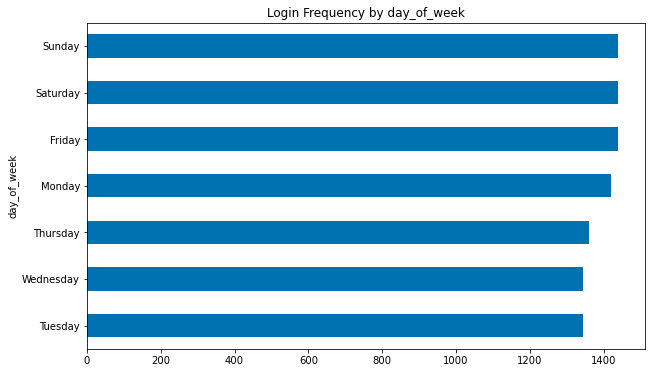

In [28]:
## Grouping by day_of_week
plt.title('Login Frequency by day_of_week')
plt.ylabel('Count')
df1.groupby("day_of_week")['login_time'].count().sort_values().plot(kind='barh')

<AxesSubplot:title={'center':'Login Frequency by Week'}, ylabel='week'>

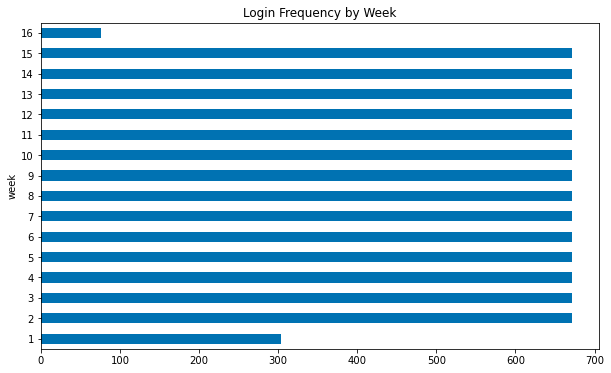

In [29]:
## Grouping by week 
plt.title('Login Frequency by Week')
plt.ylabel('Count')
df1.groupby("week")['login_time'].count().plot(kind='barh')

<AxesSubplot:title={'center':'Login Frequency by Month'}, ylabel='month'>

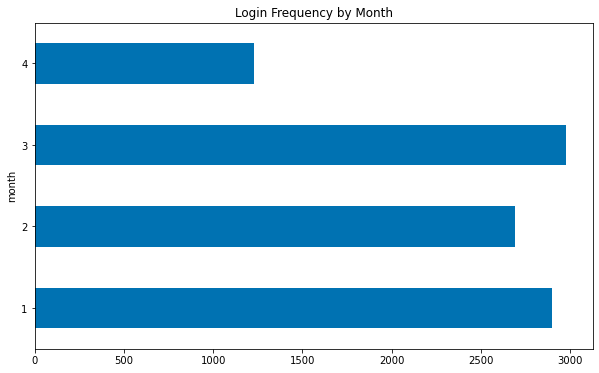

In [30]:
## Grouping by month 
plt.title('Login Frequency by Month')
plt.ylabel('Count')
df1.groupby("month")['login_time'].count().plot(kind='barh')

<AxesSubplot:title={'center':'Login Frequency by Day'}, ylabel='day'>

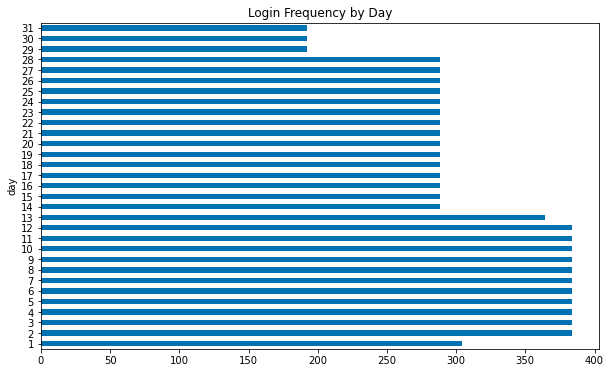

In [31]:
## Grouping by Day 
plt.title('Login Frequency by Day')
plt.ylabel('Count')
df1.groupby("day")['login_time'].count().plot(kind='barh')

Plotting the time series based on 15-minute intervals (aggregate) by day, month, week_day reveals that : 
- day: users are more active on the first 13 days of the month, and moderately so between the 14th and 27th day, they are less active at the end of the month
- months: users are more active in the first 3 months and less active in April.  
- week_of_day: users are more active from Sunday to Monday and less active from Tuesday to Thursday.

In [32]:
## Initiating Pandas Profile for a quick overview of the dataset 
#import pandas_profiling

#pandas_profiling.ProfileReport(df1)

#  Part 3 predictive modelling  

### 3.1 Cleaning, exploratory analysis, and visualizations

In [33]:
data = pd.read_json('ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [34]:
data.shape

(50000, 12)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [37]:
data.nunique()

city                         3
trips_in_first_30_days      59
signup_date                 31
avg_rating_of_driver        37
avg_surge                  115
last_trip_date             182
phone                        2
surge_pct                  367
ultimate_black_user          2
weekday_pct                666
avg_dist                  2908
avg_rating_by_driver        27
dtype: int64

In [38]:
data.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [39]:
data.duplicated().sum()

8

In [40]:
data[data.duplicated()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
34641,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
36627,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
42025,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0


In [41]:
# convert signup_date and last_trip_date to DateTime 
data['signup_date'] = pd.to_datetime(data['signup_date'], format='%Y-%m-%d')
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'], format='%Y-%m-%d')

In [42]:
# signup took one month form january 1st to 31
data['signup_date'].min(), data['signup_date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-01-31 00:00:00'))

In [43]:
# trip start on 1st january to 1st jully the same year 2014
data['last_trip_date'].min(), data['last_trip_date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

In [44]:
# retain user or 'active'
sum(data.last_trip_date > '2014-06-01') / len(data)

0.3662

In [45]:
# Calculate 30 days delta
delta = pd.Timedelta('30 days')
delta

Timedelta('30 days 00:00:00')

In [46]:
# Label active user ( the time between thier max date and the max date (reference) should be lower to 30 days)
data['active']= data['last_trip_date'].max()- data.last_trip_date <= delta
data.active.value_counts(normalize=True)*100

False    62.392
True     37.608
Name: active, dtype: float64

In [47]:
data['last_trip_date'].max()- data.last_trip_date <= delta

0         True
1        False
2        False
3         True
4        False
         ...  
49995     True
49996    False
49997    False
49998    False
49999    False
Name: last_trip_date, Length: 50000, dtype: bool

In [48]:
data['last_trip_date'].max()- data.last_trip_date

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: last_trip_date, Length: 50000, dtype: timedelta64[ns]

In [49]:
data['active'].mean()*100

37.608000000000004

### exploratory data analysis 

In [50]:
df= data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active                  50000 non-null  bool  

In [51]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [52]:
df.avg_surge.unique().sum()

217.79999999999998

In [53]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [54]:
df.ultimate_black_user.unique()

array([ True, False])

In [55]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [56]:
df['active']= df['active'].astype(int)

### visualize categorical variable 

<AxesSubplot:>

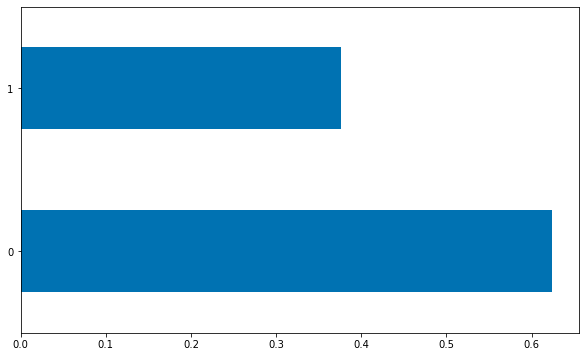

In [57]:
df['active'].value_counts(normalize=True).plot.barh()

In [58]:
non_num_col=['city', 'phone', 'ultimate_black_user']

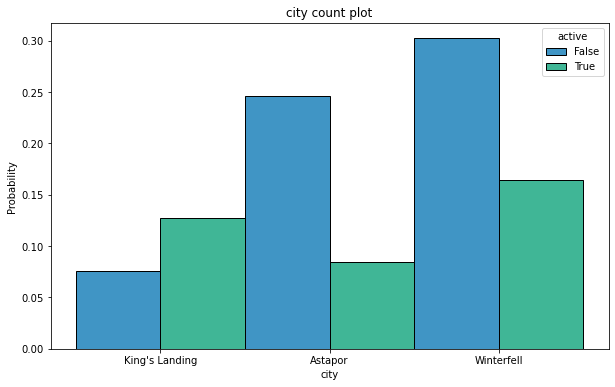

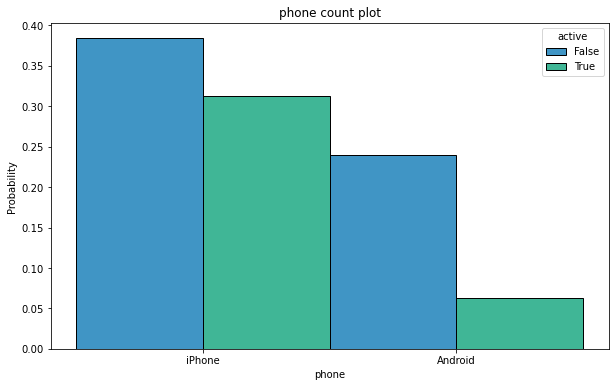

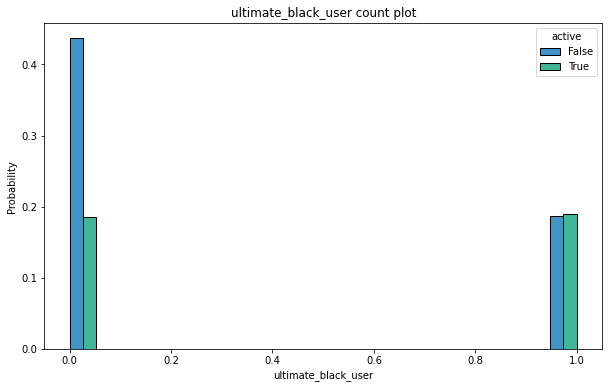

In [59]:
for col in non_num_col:
    sns.histplot(x=col,data=df, hue=data['active'], stat="probability", multiple="dodge")
    #sns.countplot(x=f,data=data, hue=data['HeartDisease'])
    plt.title(col+' count plot')
    plt.show()

In [60]:
# get the munerical features
numerical=[f for f in data.columns if data[f].dtype =='float64']
numerical

['avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver']

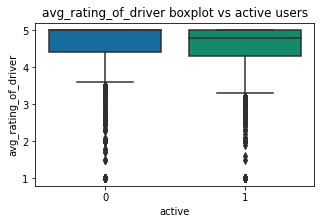

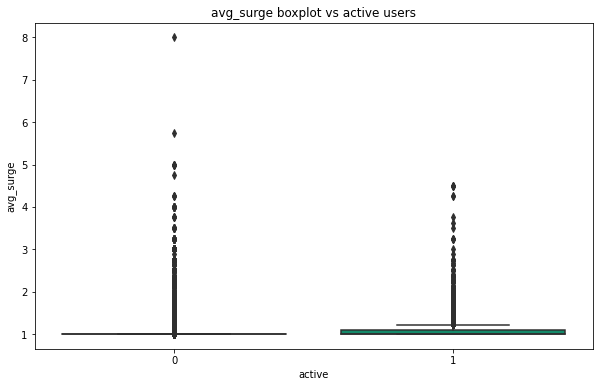

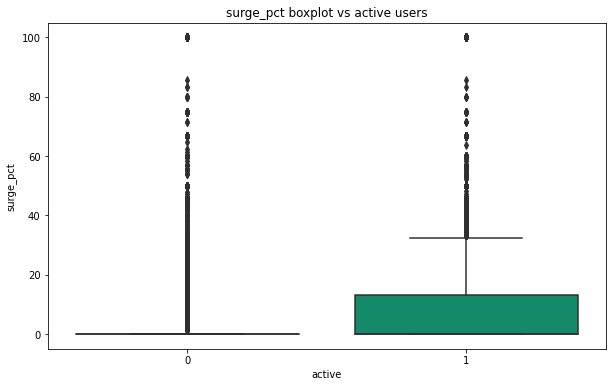

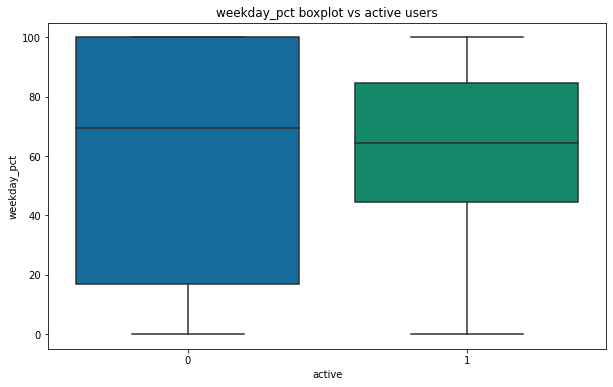

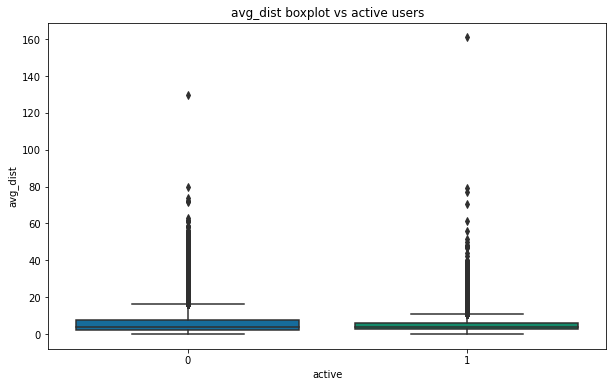

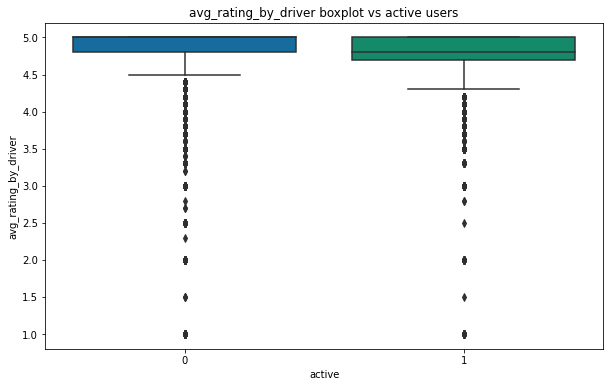

In [61]:
plt.figure(figsize=(5, 3))
for f in numerical:
    sns.boxplot(x='active', y=f, data=df )
    plt.title(f+' boxplot vs active users')
    plt.show()

<Figure size 216x144 with 0 Axes>

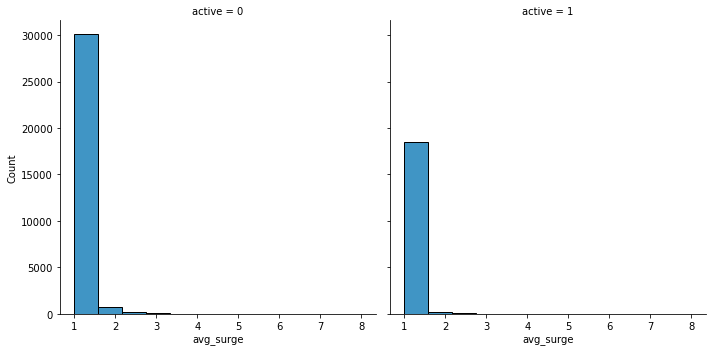

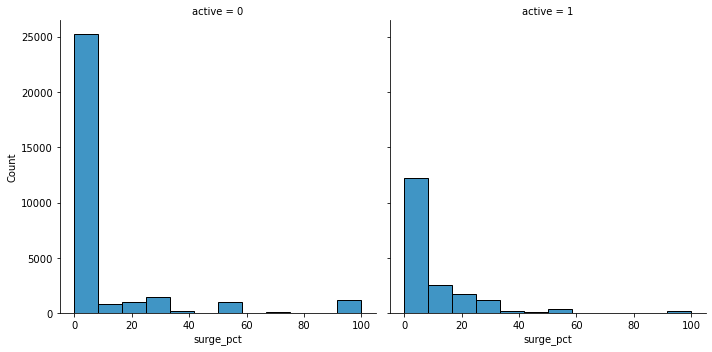

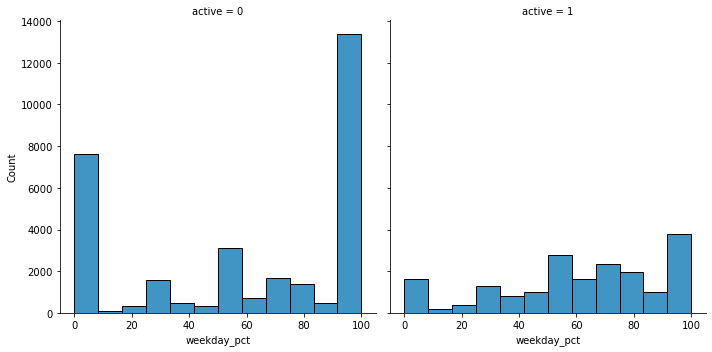

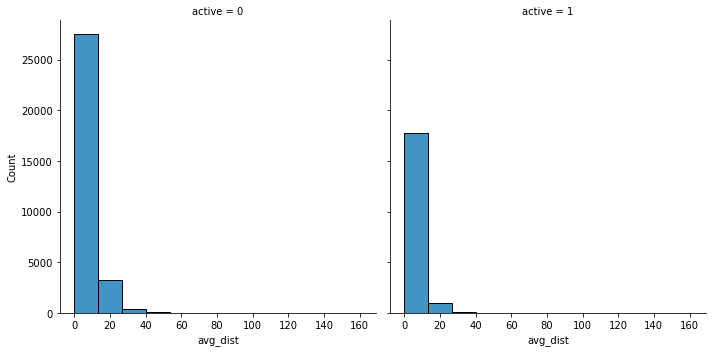

In [62]:
plt.figure(figsize=(3, 2))
for f in ['avg_surge','surge_pct', 'weekday_pct', 'avg_dist']:
    sns.displot(data= df, x=f, col = 'active', bins=12, kde=False )

<Figure size 360x216 with 0 Axes>

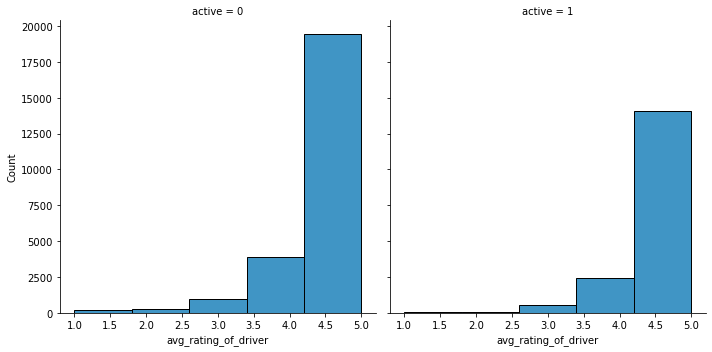

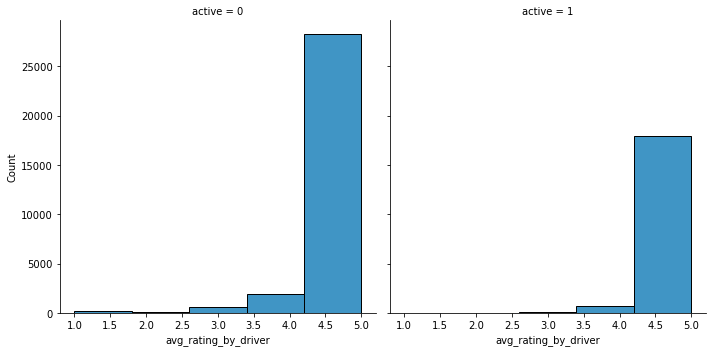

In [63]:
plt.figure(figsize=(5, 3))
for f in ['avg_rating_of_driver','avg_rating_by_driver']:
    sns.displot(data= df, x=f, col = 'active', bins=5, kde=False )

<AxesSubplot:xlabel='variable', ylabel='value'>

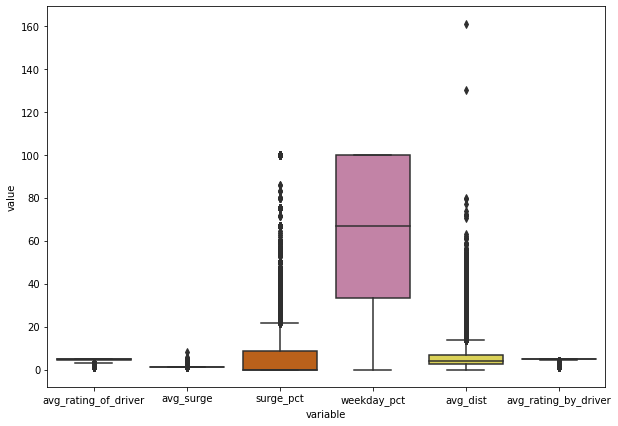

In [64]:
#melt data frame into long format
plt.figure(figsize=(10, 7))
data_melted = pd.melt(df[numerical])
sns.boxplot(x='variable', y='value', data=data_melted)

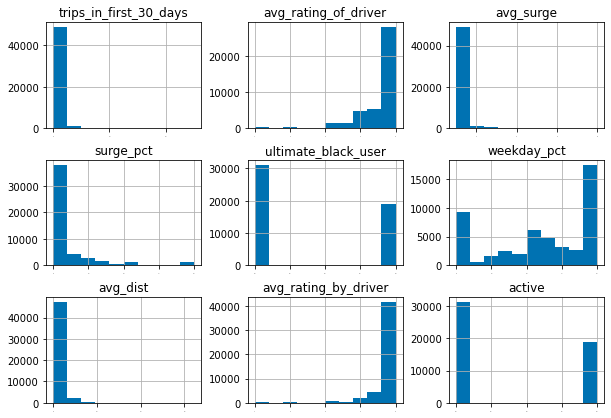

In [65]:
df.select_dtypes(include=['float', 'int']).hist(figsize=(10,7), sharex=False, sharey=False, xlabelsize=1)
plt.show()

### biVariete analysis 

In [66]:
city_trip = (df[['trips_in_first_30_days', 'city']].groupby('city').sum().reset_index())
city_trip

,city,trips_in_first_30_days
0,Astapor,32219
1,King's Landing,24957
2,Winterfell,56734


Text(0.5, 1.0, 'Trips vs. City')

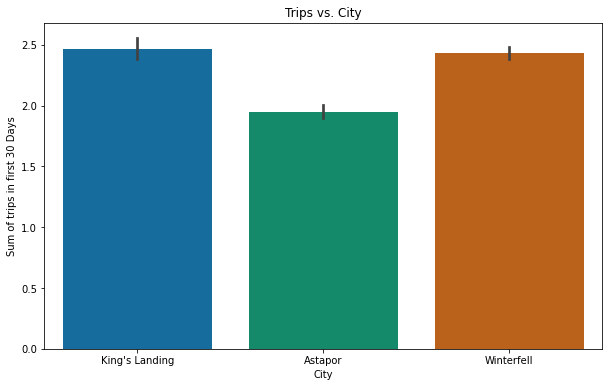

In [67]:
# Constructing barplot
sns.barplot(x='city', y='trips_in_first_30_days', data=df)
plt.ylabel('Sum of trips in first 30 Days')
plt.xlabel('City')
plt.title('Trips vs. City')

Text(0.5, 1.0, 'ultimate_black_user vs. City')

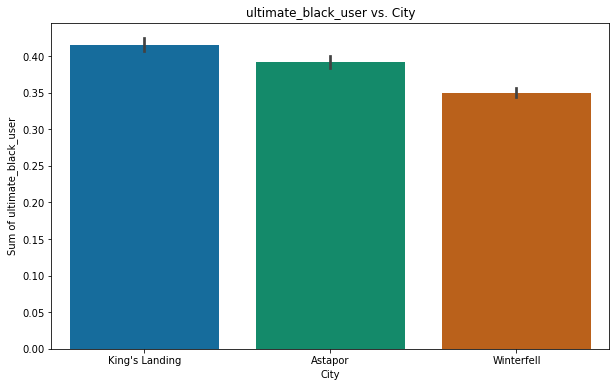

In [68]:
sns.barplot(x='city', y='ultimate_black_user', data=df)
plt.ylabel('Sum of ultimate_black_user')
plt.xlabel('City')
plt.title('ultimate_black_user vs. City')

Text(0.5, 1.0, 'active_user vs. City')

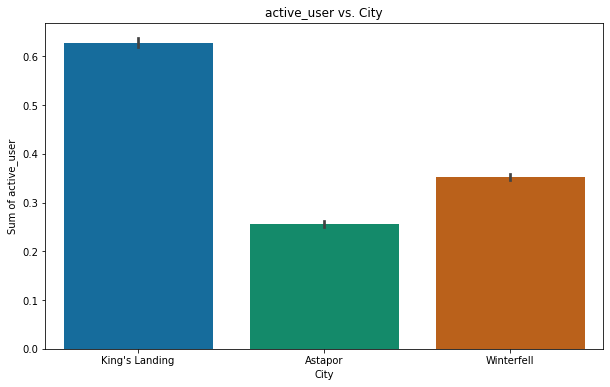

In [69]:
sns.barplot(x='city', y='active', data=df)
plt.ylabel('Sum of active_user')
plt.xlabel('City')
plt.title('active_user vs. City')

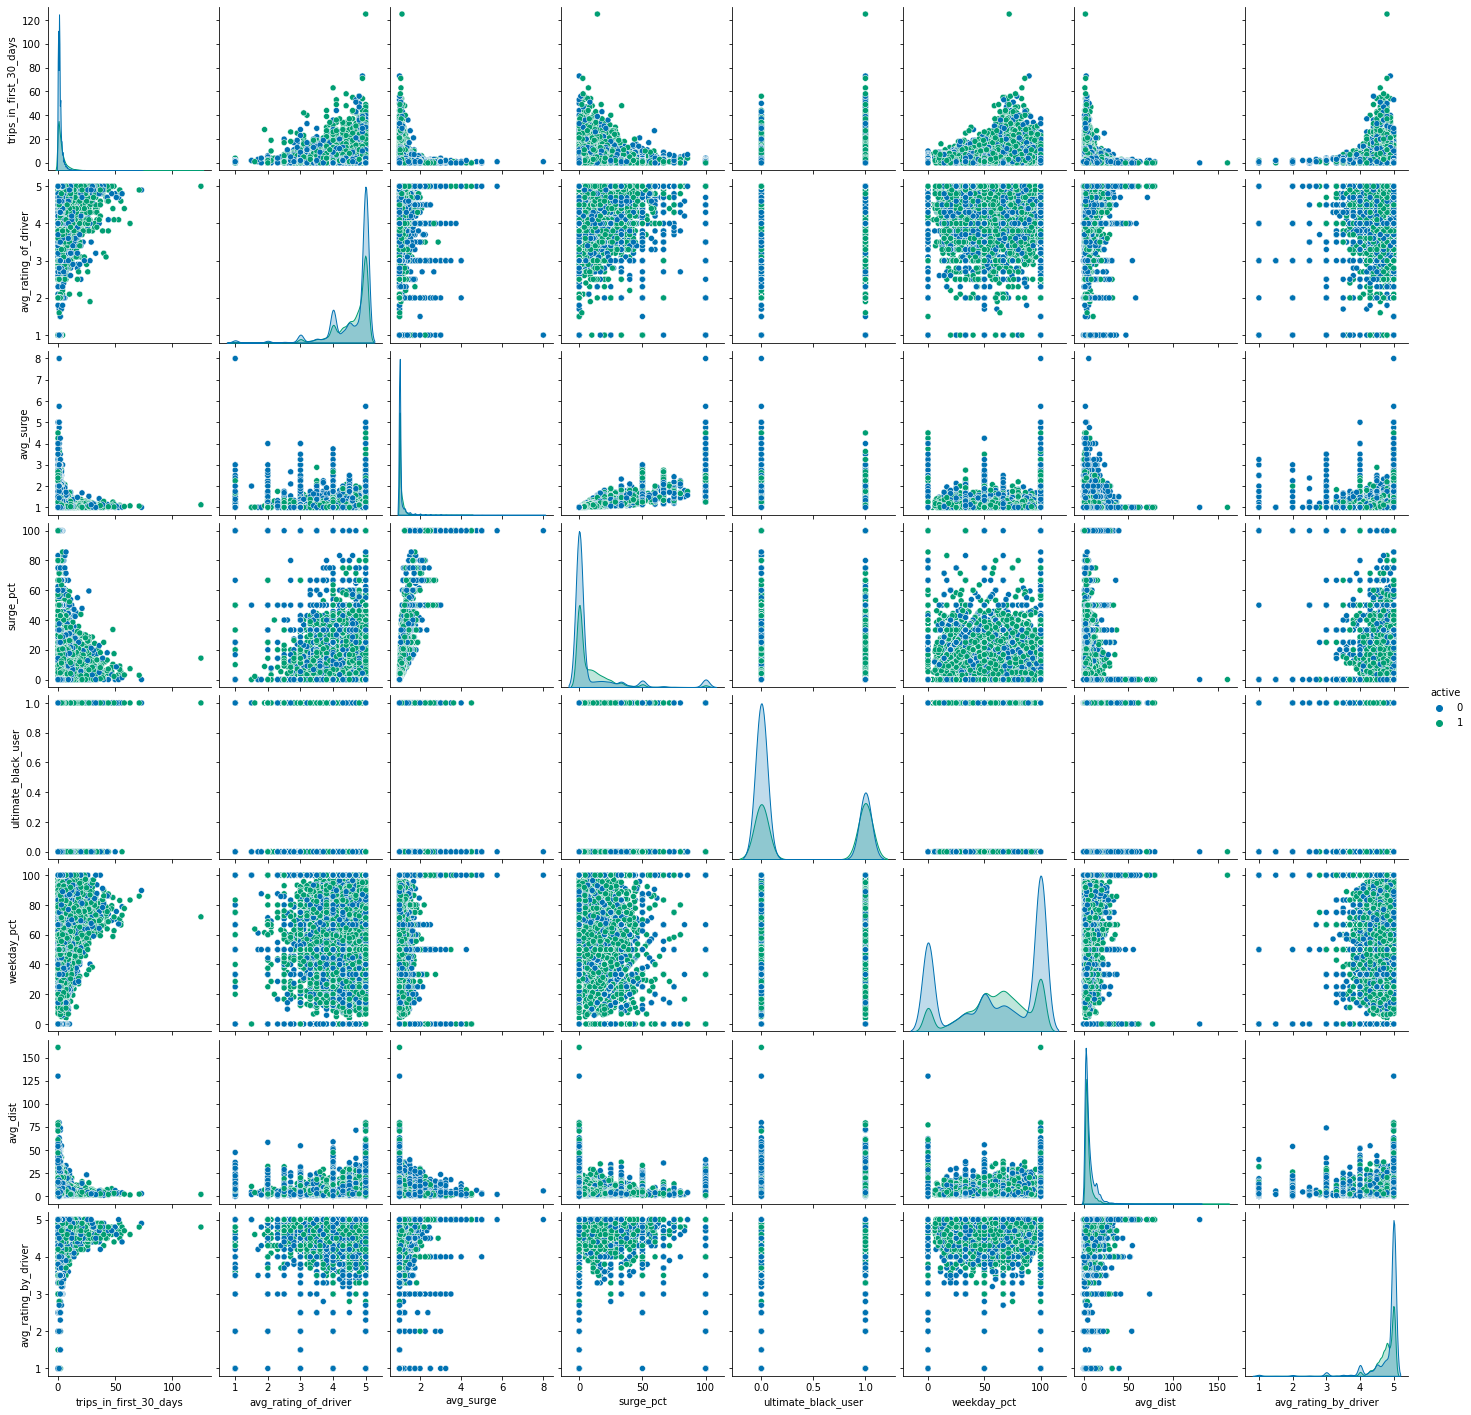

In [70]:
#plt.figure(figsize=(10,6))
sns.pairplot(data=df, hue='active')
plt.show()

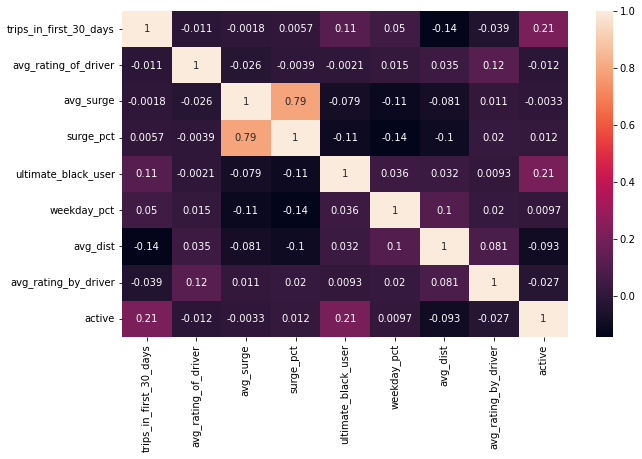

In [71]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)
plt.show()

## Modeling 

In [72]:
# Impute in missing values

In [73]:
df1 = data.copy(deep=True)

In [74]:
df1.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active'],
      dtype='object')

In [75]:
avg = df1['avg_rating_by_driver'].mean()
df1['avg_rating_by_driver'].fillna(avg, inplace=True)

avg = df1['avg_rating_of_driver'].mean()
df1['avg_rating_of_driver'].fillna(avg, inplace=True)

In [76]:
#df1['phone'].fillna('Other', inplace = True)
# fill NaN with 0
df1.phone.fillna(0, inplace=True)
# change invited_by_user_id to binary value(1, 0)
df1.phone = df1.phone.apply(lambda x: 1 if x != 0 else x)

In [77]:
df1.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
active                    0
dtype: int64

In [78]:
non_num_col=['city', 'ultimate_black_user', 'active']

In [79]:
# encode non numerical features
lb=LabelEncoder()
df1[non_num_col] = df1[non_num_col].apply(lambda col: lb.fit_transform(col))

In [80]:
df1.head(2)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,1,4,2014-01-25,4.7,1.1,2014-06-17,1,15.4,1,46.2,3.67,5.0,1
1,0,0,2014-01-29,5.0,1.0,2014-05-05,1,0.0,0,50.0,8.26,5.0,0


In [81]:
df1.dtypes

city                               int32
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                              int64
surge_pct                        float64
ultimate_black_user                int64
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
active                             int64
dtype: object

In [82]:
# get the predictors
df1.drop(['signup_date','last_trip_date'], axis=1, inplace=True)
X=df1.drop('active',axis=1)
X.head(2)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,1,4,4.7,1.1,1,15.4,1,46.2,3.67,5.0
1,0,0,5.0,1.0,1,0.0,0,50.0,8.26,5.0


In [83]:
# get the target feature
y=df1['active']
y.head(3)

0    1
1    0
2    0
Name: active, dtype: int64

In [84]:
# split the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=47)

### logistic regression 

#### using pipeline

In [85]:
from sklearn.pipeline import make_pipeline

In [86]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [87]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
pipe.score(X_test, y_test)

0.67432

In [88]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6973  865]
 [3206 1456]]
              precision    recall  f1-score   support

           0       0.69      0.89      0.77      7838
           1       0.63      0.31      0.42      4662

    accuracy                           0.67     12500
   macro avg       0.66      0.60      0.60     12500
weighted avg       0.66      0.67      0.64     12500



In [89]:
# Compute and print AUC score
y_pred_prob = pipe.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.6762513616302849


##### No scaling of data 

In [90]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6988  850]
 [3231 1431]]
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      7838
           1       0.63      0.31      0.41      4662

    accuracy                           0.67     12500
   macro avg       0.66      0.60      0.59     12500
weighted avg       0.66      0.67      0.64     12500



C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


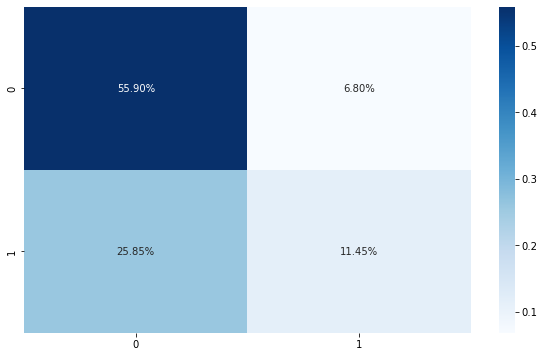

In [91]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [92]:
# get importance
importance = log_reg.coef_
importance

array([[ 1.64453936e-01,  1.16519703e-01,  9.75770799e-03,
        -3.16648631e-01, -7.37840423e-03,  5.67827354e-03,
         8.39819996e-01,  2.73534920e-04, -3.06517705e-02,
        -1.54791813e-01]])

In [93]:
# plot feature importance
df_coef = pd.DataFrame(zip(list(X_train.columns),log_reg.coef_[0]),index=range(X_train.columns.shape[0]),columns=['feature','coefficient'])
df_coef.sort_values(by='feature')

,feature,coefficient
8,avg_dist,-0.030652
9,avg_rating_by_driver,-0.154792
2,avg_rating_of_driver,0.009758
3,avg_surge,-0.316649
0,city,0.164454
4,phone,-0.007378
5,surge_pct,0.005678
1,trips_in_first_30_days,0.116520
6,ultimate_black_user,0.839820
7,weekday_pct,0.000274


Text(0.5, 1.0, 'plot feature importance')

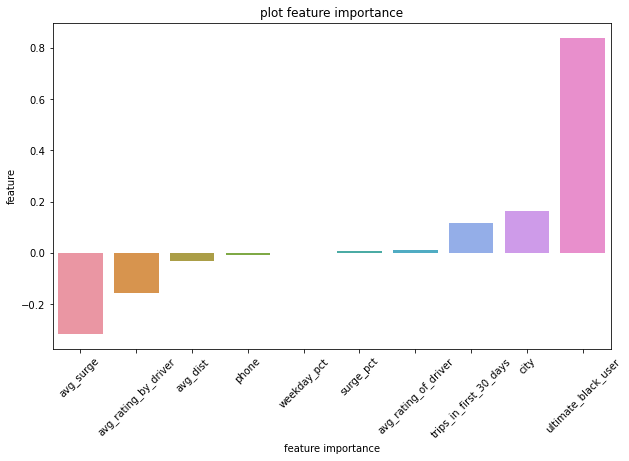

In [94]:
sns.barplot(x='feature', y='coefficient', data=df_coef.sort_values(by='coefficient') )
plt.ylabel('feature')
plt.xlabel('feature importance' )
plt.xticks(rotation=45)
plt.title('plot feature importance')

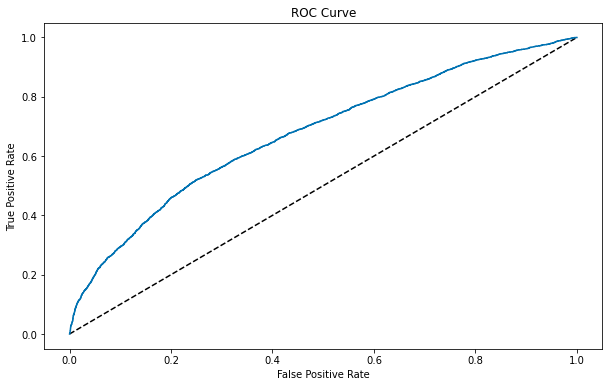

In [95]:
# Compute predicted probabilities: y_pred_prob and  Generate ROC curve values: fpr, tpr, thresholds
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [96]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(log_reg, X_train, y_train, cv = 5, scoring = 'roc_auc')

AUC: 0.6769511282142056


C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mirei\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [97]:
# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.67363864 0.68405871 0.6680282  0.66411446 0.66836909]


In [98]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.6769511282142056


### random Forest 

#### 1st random forest model

In [99]:
clf = RandomForestClassifier(random_state=0, n_estimators = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [100]:
#from sklearn import metrics
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.74344


In [101]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test,y_pred)
print(cf_matrix)

[[6236 1602]
 [1605 3057]]


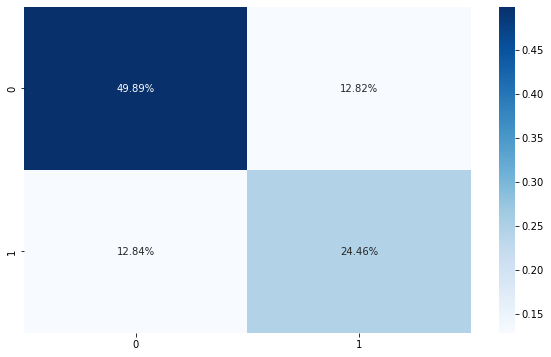

In [102]:
ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7838
           1       0.66      0.66      0.66      4662

    accuracy                           0.74     12500
   macro avg       0.73      0.73      0.73     12500
weighted avg       0.74      0.74      0.74     12500



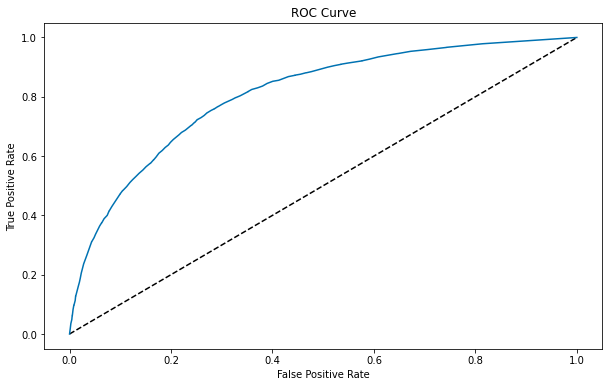

In [104]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [105]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8074279306098647


#### 2nd tune random forest model 

In [106]:
# define hyperparams
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [2,4,6,8, 10]
min_samples_split = [2,3, 4, 5]
min_samples_leaf = [1,2, 3]
bootstrap = [True, False]

In [107]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 14, 19, 24, 28, 33, 38, 43, 47, 52, 57, 62, 66, 71, 76, 81, 85, 90, 95, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [108]:
rf_Model = RandomForestClassifier()

In [109]:
# n_jobs -1, all CPUs are used.
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = -1, random_state=0)

In [110]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [10, 14, 19, 24, 28, 33,
                                                         38, 43, 47, 52, 57, 62,
                                                         66, 71, 76, 81, 85, 90,
                                                         95, 100]},
                   random_state=0, verbose=2)

In [111]:
best_random = rf_RandomGrid.best_params_
rf_RandomGrid.best_params_

{'n_estimators': 71,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [112]:
rfOpt = RandomForestClassifier(n_estimators= 24, min_samples_split= 2, min_samples_leaf=3, max_features= 'auto', max_depth= 10,bootstrap=True)
rfOpt = rfOpt.fit(X_train, y_train)
y_pred = rfOpt.predict(X_test)

In [113]:
rfOpt.score(X_test,y_test) , rfOpt.score(X_train,y_train)

(0.77128, 0.79864)

In [114]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.804
Test Accuracy - : 0.773


In [115]:
target_names = ['No_active', 'active']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No_active       0.79      0.86      0.83      7838
      active       0.73      0.61      0.67      4662

    accuracy                           0.77     12500
   macro avg       0.76      0.74      0.75     12500
weighted avg       0.77      0.77      0.77     12500



In [116]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test,y_pred)
print(cf_matrix)

[[6776 1062]
 [1797 2865]]


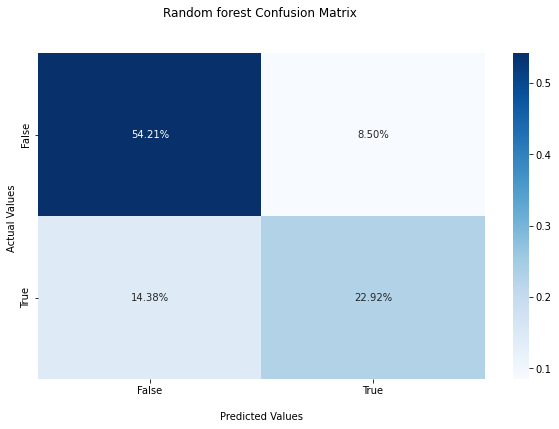

In [117]:
ax=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Random forest Confusion Matrix \n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [118]:
importances = rfOpt.feature_importances_
#feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = [f"feature {i}" for i in X.columns]
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in  rfOpt.estimators_], axis=0)

In [119]:
forest_importances

feature surge_pct                 0.182357
feature avg_rating_by_driver      0.158912
feature weekday_pct               0.152127
feature city                      0.139626
feature avg_surge                 0.104071
feature trips_in_first_30_days    0.083825
feature ultimate_black_user       0.082029
feature avg_dist                  0.062958
feature avg_rating_of_driver      0.033291
feature phone                     0.000804
dtype: float64

Text(0.5, 1.0, 'Random forest Feature importances ')

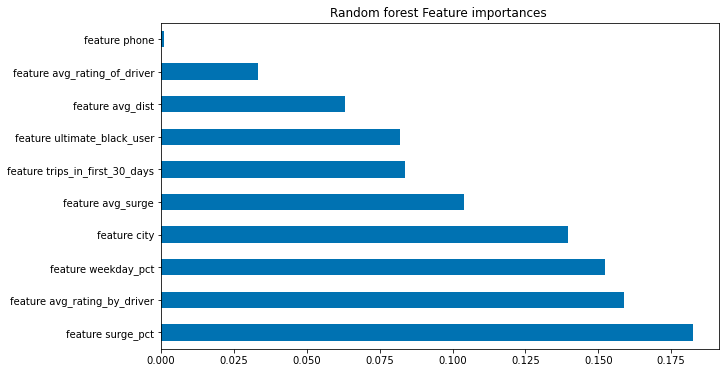

In [120]:
forest_importances.plot.barh()
plt.title("Random forest Feature importances ")

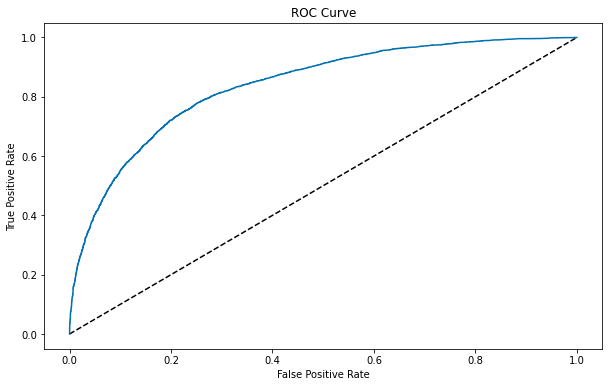

In [121]:
#from sklearn.metrics import roc_curve
y_pred_prob = rfOpt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [122]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.838249145693647


### XGBoost Model

In [123]:
# XGBOOST Model - 1rst model 
XGB = XGBClassifier(n_estimators=1000,learning_rate=0.05)
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
accuracy = accuracy_score(y_test,y_pred) #predictions
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[18:04:04] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mirei\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 77.83%


In [124]:
target_names = ['No_active', 'active']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No_active       0.81      0.85      0.83      7838
      active       0.72      0.66      0.69      4662

    accuracy                           0.78     12500
   macro avg       0.76      0.75      0.76     12500
weighted avg       0.78      0.78      0.78     12500



[18:04:14] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mirei\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

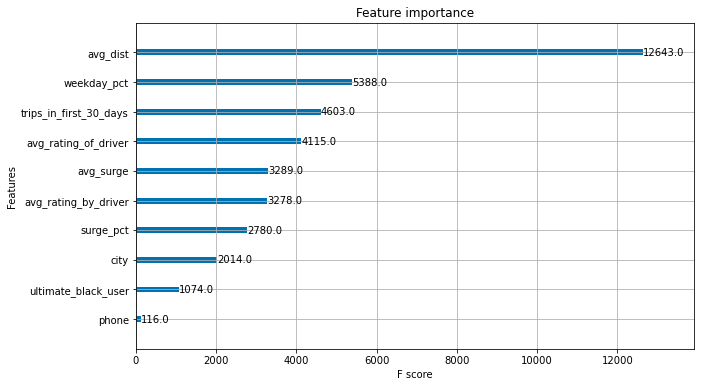

In [125]:
plot_importance(XGB.fit(X_train, y_train))

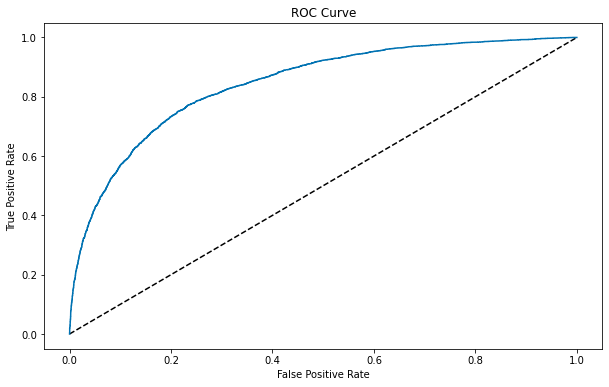

In [126]:
y_pred_prob = XGB.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [127]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8439893936512972


### XGBOOST Model - 2nd model 

In [128]:
# XGBOOST Model - 2nd model 
xgbb = XGBClassifier()
xgbb= XGBClassifier(n_estimators=1000,learning_rate=0.05,use_label_encoder=False )
xgbb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

[18:04:23] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [129]:
xgbb=XGBClassifier(n_estimators = xgbb.best_iteration)
xgbb.fit(X_train, y_train)

C:\Users\mirei\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:25] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=146, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [130]:
y_pred = xgbb.predict(X_test)
target_names = ['No_active', 'active']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No_active       0.81      0.85      0.83      7838
      active       0.72      0.66      0.69      4662

    accuracy                           0.78     12500
   macro avg       0.76      0.75      0.76     12500
weighted avg       0.77      0.78      0.77     12500



[18:04:26] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mirei\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

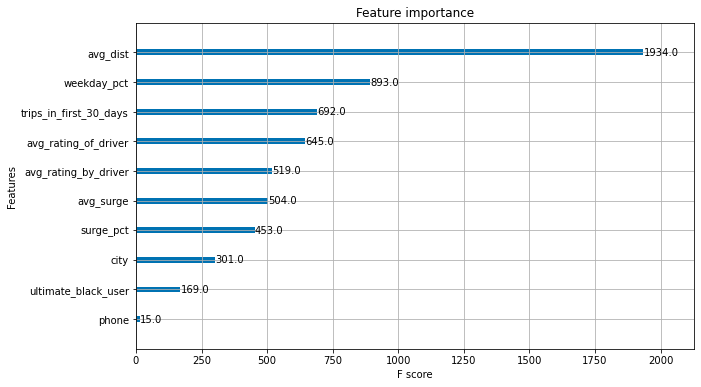

In [131]:
plot_importance(xgbb.fit(X_train,y_train))

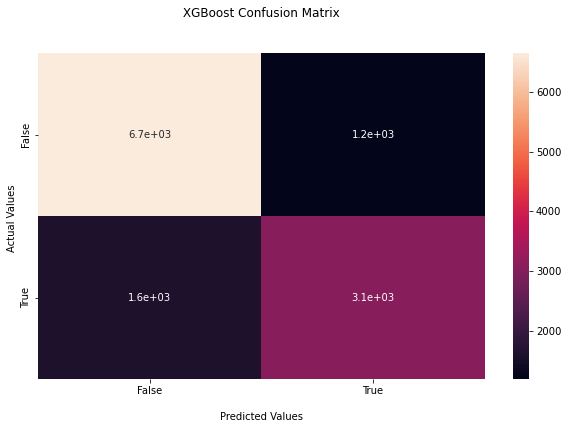

In [132]:
ax=sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
ax.set_title(' XGBoost Confusion Matrix \n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

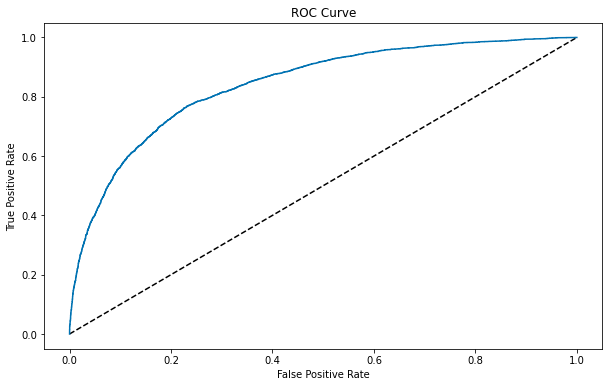

In [133]:
y_pred_prob = xgbb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [134]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8412396831636433


## XGBOOST Tune

In [135]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [136]:
parameters = {
    'max_depth': [int(x) for x in np.linspace(start = 5, stop = 20, num = 10)],
    'n_estimators':[int(x) for x in np.linspace(start = 10, stop = 100, num = 20)],
    'learning_rate': [0.1, 0.01, 0.05]
}

In [137]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [138]:
#grid_search.fit(X_train, y_train) # (4 hours of runnig time)

In [139]:
#grid_search.best_estimator_

#grid_search.best_estimator_
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None

In [140]:
#xgb_grid = grid_search.best_estimator_

In [141]:
#y_pred = xgb_grid.predict(X_test)

In [142]:
#print(classification_report(y_test,y_pred))

In [143]:
#plot_importance(xgb_grid.fit(X_train,y_train))